<a href="https://colab.research.google.com/github/Gokul0Krishna/pytorchpractice/blob/master/2nd_attempt_ipynb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!unzip "/content/washer.v1i.multiclass.zip"
!unzip "/content/test.zip"
!unzip "/content/washer.v4i.multiclass.zip"

Archive:  /content/washer.v1i.multiclass.zip
   creating: washer.v1i.multiclass/
  inflating: washer.v1i.multiclass/README.dataset.txt  
  inflating: washer.v1i.multiclass/README.roboflow.txt  
   creating: washer.v1i.multiclass/train/
  inflating: washer.v1i.multiclass/train/Image__2023-01-31__15-55-57_bmp.rf.18a08acd6f9afc28fa897edda5e614a2.jpg  
  inflating: washer.v1i.multiclass/train/Image__2023-01-31__15-55-57_bmp.rf.441bfa5b39229d171cbdb365a92ba4bf.jpg  
  inflating: washer.v1i.multiclass/train/Image__2023-01-31__15-55-57_bmp.rf.6cf65a9c6d2daad6ef9bc0b6f9277ec7.jpg  
  inflating: washer.v1i.multiclass/train/Image__2023-01-31__15-56-06_bmp.rf.12926af8e7ac852ce770ae65b9056cbc.jpg  
  inflating: washer.v1i.multiclass/train/Image__2023-01-31__15-56-06_bmp.rf.84df478f5b689f5c3a267484146cb03a.jpg  
  inflating: washer.v1i.multiclass/train/Image__2023-01-31__15-56-06_bmp.rf.9c8d0fdcf2d1327bf14e53b7642a5470.jpg  
  inflating: washer.v1i.multiclass/train/Image__2023-01-31__15-56-20_bmp.r

In [2]:
import os

In [3]:
images=[]
lables=[]
for i in os.listdir("/content/washer.v4i.multiclass"):
  for j in os.listdir("/content/washer.v4i.multiclass/"+i):
    if j.endswith(".jpg") == True:
      images.append("/content/washer.v4i.multiclass/"+i+"/"+j)
      lables.append("washer")

for i in os.listdir("/content/washer.v1i.multiclass"):
    if i.endswith(".txt") == False:
      for j in os.listdir("/content/washer.v1i.multiclass/"+i):
        if j.endswith(".jpg") == True:
          images.append("/content/washer.v1i.multiclass/"+i+"/"+j)
          lables.append("washer")


In [4]:
len(images)

251

In [5]:
a=0
for i in os.listdir("/content/test"):
  for j in os.listdir("/content/test/"+i):
      if a>250:
          break
      images.append("/content/test/"+i+"/"+j)
      lables.append("bolts")
      a+=1

In [6]:
a=sum(1 for i in lables if i=="bolts")
print(len(lables)-a,a)

251 251


In [7]:
import pandas as pd
df=pd.DataFrame({'X':images,'Y':lables})
df=pd.get_dummies(df,columns=['Y'],dtype=float)
df.columns = df.columns.str.replace("Y_", "")
# df=df.sample(frac=1)
df.head()

,X,bolts,washer
0,/content/washer.v4i.multiclass/valid/36_jpg.rf...,0.0,1.0
1,/content/washer.v4i.multiclass/valid/53_jpg.rf...,0.0,1.0
2,/content/washer.v4i.multiclass/valid/25_jpg.rf...,0.0,1.0
3,/content/washer.v4i.multiclass/valid/3_jpg.rf....,0.0,1.0
4,/content/washer.v4i.multiclass/valid/8_jpg.rf....,0.0,1.0


In [8]:
l=["bolts","washer"]
from sklearn.model_selection import train_test_split
xtrain, xtest,ytrain,ytest = train_test_split(df['X'],df[l],random_state=42, test_size=0.2)
xtest, xval,ytest,yval = train_test_split(xtest,ytest,random_state=42, test_size=0.5)

In [9]:
import torch
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
import torch.nn as nn

In [10]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [11]:
from PIL import Image
import numpy as np
class customdataset(Dataset):
    def __init__(self,x,y,transform=None):
        self.x=x
        self.y=y
        self.transform=transform

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, index):
        imgpath=self.x.iloc[index]
        if self.transform:
            image=Image.open(imgpath).convert("RGB")
            image=self.transform(image)
        label_row = self.y.iloc[index, 0:2]
        label_tensor = torch.tensor(label_row.values.astype(np.float32))
        label_index = torch.argmax(label_tensor).item()

        return image,label_index

In [12]:
traindataset=customdataset(x=xtrain,y=ytrain,transform=preprocess)
testdataset=customdataset(x=xtest,y=ytest,transform=preprocess)
valdataset=customdataset(x=xval,y=yval,transform=preprocess)

In [13]:
trainloader=DataLoader(traindataset,batch_size=40,shuffle=True)
testloader=DataLoader(testdataset,batch_size=40,shuffle=True)
valloader=DataLoader(valdataset,batch_size=40,shuffle=True)

In [36]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'densenet121', pretrained=True)

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
testmodel=model

In [38]:
for param in testmodel.parameters():
    param.requires_grad = False
criterion = nn.CrossEntropyLoss()
testmodel.classifier = nn.Linear(testmodel.classifier.in_features, 2)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
testmodel = testmodel.to(device)
optimizer = torch.optim.Adam([
    {'params': testmodel.classifier.parameters(), 'lr': 0.001},  # Higher LR for new layers
    {'params': testmodel.features.parameters(), 'lr': 0.00001}    # Lower LR for pretrained
], weight_decay=1e-5)

In [33]:
i=0
epoch=True
prevlossv,patience=0,0
while epoch:
    testmodel.train()
    trunningloss,vrunningloss=0.0,0.0
    ttotal,vtotal = 0,0
    tacc,vacc=0.0,0.0
    for inputs, labels in trainloader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = testmodel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        trunningloss += loss.item()
        _, predicted = torch.max(outputs.data, 1)  # Get predicted class
        ttotal += labels.size(0)
        tacc += (predicted == labels).sum().item()


    testmodel.eval()
    with torch.no_grad():
      for inputs, labels in valloader:
          inputs, labels = inputs.to(device), labels.to(device)

          optimizer.zero_grad()
          outputs = testmodel(inputs)
          loss = criterion(outputs, labels)
          vrunningloss += loss.item()

          _, predicted = torch.max(outputs.data, 1)  # Get predicted class
          vtotal += labels.size(0)
          vacc += (predicted == labels).sum().item()

    print("="*20)
    print(f"""Epoch {i+1}
          train
          Loss: {trunningloss/len(trainloader)}
          Accuracy: {tacc*100/ttotal}
          val
          Loss: {vrunningloss/len(valloader)}
          Accuracy: {vacc*100/vtotal}
          """)
    i+=1

    if(vrunningloss/len(valloader))<prevlossv:
        prevlossv=vrunningloss/len(valloader)
        patience=0
    else:
      patience+=1
      if patience>5:
        pass
    epoch=False




Epoch 1
          train
          Loss: 0.4174823774532838
          Accuracy: 88.7780548628429
          val
          Loss: 0.15853559970855713
          Accuracy: 100.0
          


In [39]:
for i in range(2):
    ttloss=0
    tacc=0
    ttsample=0

    vtloss=0
    vacc=0
    vtsample=0

    model.train()

    for value,label in trainloader:
        optimizer.zero_grad()
        output=model(value)
        if label.dim() > 1:
            label = torch.argmax(label, dim=1)
        # loss
        batchloss=criterion(output,label)
        ttloss+=batchloss.item()*value.size(0)
        # accuracy
        _, preds = torch.max(output, 1)
        tacc+=(preds == label).sum().item()
        ttsample += label.size(0)

        batchloss.backward()
        optimizer.step()
        # optimizer.zero_grad()

    model.eval()
    with torch.no_grad():
        for value,label in valloader:
            if label.dim() > 1:
                label = torch.argmax(label, dim=1)
            output=model(value)
            # loss
            batchloss=criterion(output,label)
            vtloss+=batchloss.item()*value.size(0)
            # accuracy

            _, preds = torch.max(output, 1)
            vacc += (preds == label).sum().item()
            vtsample += label.size(0)

    tatl = ttloss / len(trainloader.dataset)
    ta = (tacc / ttsample)*100

    vatl = vtloss / len(valloader.dataset)
    va= (vacc / vtsample)*100

    print(f"""Epoch:{i+1}

          train_loss:{tatl} ,train_accuracy{ta}
          val_loss: {vatl} ,val_accuracy: {va}""")

    print("="*20)

Epoch:1
          
          train_loss:0.4551741402048125 ,train_accuracy83.29177057356608
          val_loss: 0.2487934786899417 ,val_accuracy: 98.0392156862745
Epoch:2
          
          train_loss:0.206609720452468 ,train_accuracy97.50623441396509
          val_loss: 0.11595260614857954 ,val_accuracy: 100.0
Epoch:3
          
          train_loss:0.17597277860094485 ,train_accuracy94.2643391521197
          val_loss: 0.09694660308898664 ,val_accuracy: 100.0
Epoch:4
          
          train_loss:0.1101821357026659 ,train_accuracy98.25436408977556
          val_loss: 0.13298682926916608 ,val_accuracy: 98.0392156862745


In [40]:
terunningloss,teacc=0.0,0.0
tetotal=0

testmodel.eval()
with torch.no_grad():
  for inputs, labels in testloader:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = testmodel(inputs)
      loss = criterion(outputs, labels)
      terunningloss += loss.item()

      _, predicted = torch.max(outputs.data, 1)  # Get predicted class
      tetotal += labels.size(0)
      teacc += (predicted == labels).sum().item()

print("="*20)
print(f"""
      train
      Loss: {terunningloss/len(testloader)}
      Accuracy: {teacc*100/tetotal}
      """)


      train
      Loss: 0.08361456915736198
      Accuracy: 100.0
      


In [27]:
!unzip "/content/finaltest.zip"

Archive:  /content/finaltest.zip
   creating: finaltest/
  inflating: finaltest/10_jpg.rf.2746378b9f91a509adb2df2a5d70d7cf.jpg  
  inflating: finaltest/26_jpg.rf.74a33bc5714c4d679aeb9c1b137c0064.jpg  
  inflating: finaltest/35_jpg.rf.d1028936f944a1cf8ac0995c24bd6571.jpg  
  inflating: finaltest/_classes.csv  


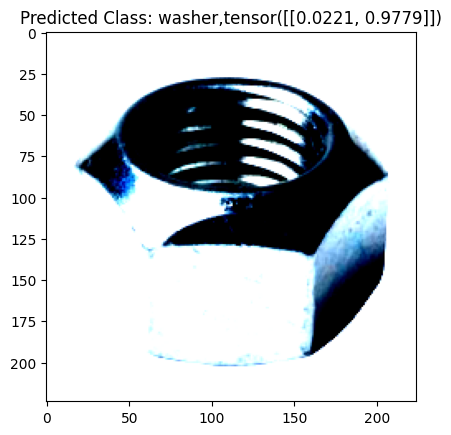

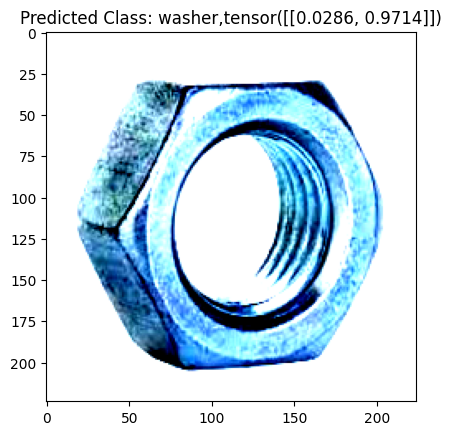

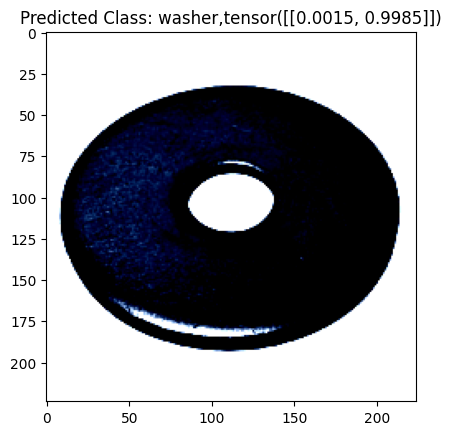

In [43]:
import cv2
from matplotlib import pyplot as plt
testmodel.eval()
for i in os.listdir("/content/finaltest"):
  if i.endswith(".jpg"):
    img=cv2.imread("/content/finaltest/"+i)
    # cv2_imshow(img)
    with torch.no_grad():
      img=Image.open("/content/finaltest/"+i).convert("RGB")
      img=preprocess(img)
      img = img.unsqueeze(0)
      img = img.to(device) # Move input to the same device as the model
      ouptut=testmodel(img)
      prob=torch.softmax(ouptut,dim=1)
      predicted_class = torch.argmax(prob).item()
      img=img.squeeze(0).permute(1,2,0).cpu().numpy()
      plt.imshow(img)
      plt.title(f"Predicted Class: {l[predicted_class]},{prob}")
      plt.show()

In [ ]:
torch.save(model, 'classifier.pth')